# Indicator of heavy rainfall

## Return value approach



In [1]:
%matplotlib inline

In [2]:
from pathlib import Path
from datetime import date

import numba
import rasterio
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from scipy import stats
from numba import jit, prange, float32
from cartopy import crs

import weather_ecmwf
import population_tools

from config import DATA_SRC, WEATHER_SRC, POP_DATA_SRC

/home/jonathanchambers/Scratch/.conda/envs/science/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [3]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

In [4]:
MAX_YEAR = 2018
REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

POPULATION_FILE = POP_DATA_SRC / 'population_count_2000-2020_30min_era_compat.nc'
# POP_FILE = POP_DATA_SRC / 'population_count_2000-2020_eightres.nc'

INTERMEDIATE_RESULTS_FOLDER = DATA_SRC / 'lancet' / 'extreme_rain'

RESULTS_FOLDER = Path('./results/lancet2019/1.5 extreme rain')
RESULTS_FOLDER.mkdir(parents=True, exist_ok=True)

EXTREME_RAIN_THRESHOLD = 1.64


In [5]:
event_counts = xr.open_mfdataset(str(INTERMEDIATE_RESULTS_FOLDER / 'ppt_ten_yearly_event_counts' / '*_event_counts.nc'))

In [6]:
population = xr.open_dataarray(POPULATION_FILE)

In [7]:
population

<xarray.DataArray 'population' (year: 21, latitude: 290, longitude: 720)>
[4384800 values with dtype=float64]
Coordinates:
  * longitude  (longitude) float64 0.0 0.5 1.0 1.5 ... 358.0 358.5 359.0 359.5
  * latitude   (latitude) float64 85.0 84.5 84.0 83.5 ... -58.5 -59.0 -59.5
  * year       (year) int64 2000 2001 2002 2003 2004 ... 2017 2018 2019 2020
Attributes:
    units:      Persons
    long_name:  UN-Adjusted Population Count, v4.10 (2000, 2005, 2010, 2015, ...
    min:        [1.13416093e-06 1.24483608e-06 1.40116185e-06 1.58567263e-06\...
    max:        [1.7137512e+07 1.7899898e+07 1.9004130e+07 2.1081032e+07 2.30...

## Express global trend as 'events per km2' (map) and 'area affected by extreme rain'


In [8]:
# Calculate grid cell areas
delta_lon = event_counts.longitude[1] - event_counts.longitude[0]
earth_radius = 6371

areas = (np.sin(np.radians(event_counts.latitude.values + delta_lon.values/2))
 - np.sin(np.radians(event_counts.latitude.values - delta_lon.values/2))) * (np.radians(delta_lon.values)) * earth_radius**2

areas = xr.DataArray(areas, dims=['latitude'], coords={'latitude': event_counts.latitude})


In [9]:
event_area_ts = (xr.where(event_counts.event_count  > 1, 1, 0) * areas).sum(dim=['latitude', 'longitude']).compute()

Text(0, 0.5, 'Million km2')

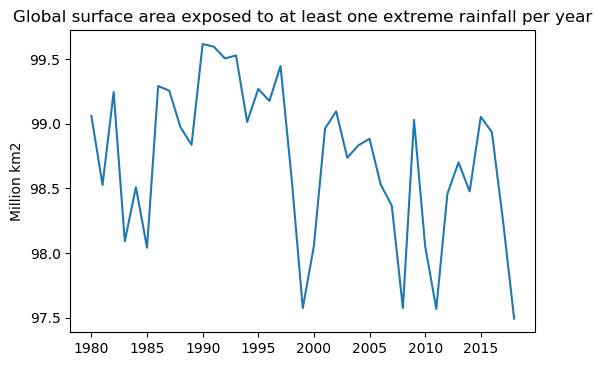

In [10]:
# (event_area_ts/ 1_000_000).plot()
(100*event_area_ts / (510.1 * 1e6)).plot()
# (event_area_ts[event_area_ts.time.dt.dayofyear > 5]/ 1_000_000).plot()
plt.title('Global surface area exposed to at least one extreme rainfall per year')
plt.xlabel('')
plt.ylabel('Million km2')


In [11]:
event_area_ts = (events * areas).sum(dim=['latitude', 'longitude']).compute()

NameError: name 'events' is not defined

In [ ]:
(event_area_ts/ 1_000_000).plot()

# (event_area_ts[event_area_ts.time.dt.dayofyear > 5]/ 1_000_000).plot()
plt.title('Global surface area exposed to extreme rainfall per year')
plt.xlabel('')
plt.ylabel('Million km2')

# plt.savefig(RESULTS_FOLDER / 'area_extreme_rainfall_ts.png', dpi=300)

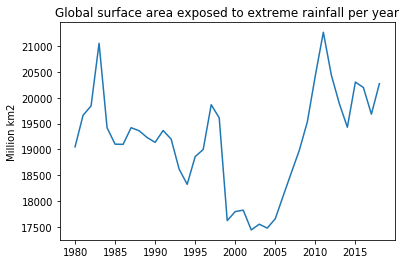

In [16]:
(event_area_ts.groupby('time.year').sum(dim='time')/ 1_000_000).plot()

# (event_area_ts[event_area_ts.time.dt.dayofyear > 5]/ 1_000_000).plot()
plt.title('Global surface area exposed to extreme rainfall per year')
plt.xlabel('')
plt.ylabel('Million km2')

plt.savefig(RESULTS_FOLDER / 'area_extreme_rainfall_ts.png', dpi=300)

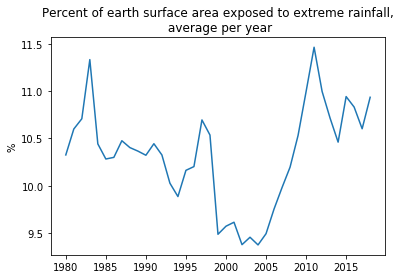

In [17]:
d = 100*event_area_ts[event_area_ts.time.dt.dayofyear > 5] / (510.1 * 1e6)
d.groupby('time.year').mean(dim='time').plot()

plt.title('Percent of earth surface area exposed to extreme rainfall,\n average per year')
plt.xlabel('')
plt.ylabel('%')

plt.savefig(RESULTS_FOLDER / 'pct_area_extreme_rainfall_ts.png', dpi=300)

## Calculate change in yearly event counts relative to 1986-2005 average

In [15]:
event_counts_change = (event_counts - 
                       event_counts.sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)).mean(dim='year'))

In [16]:
event_counts_change.to_netcdf(INTERMEDIATE_RESULTS_FOLDER / 'rain_events_change.nc')

In [17]:
event_counts_change = xr.open_dataset(INTERMEDIATE_RESULTS_FOLDER / 'rain_events_change.nc')

In [31]:
out_folder = (Path('..') / '2019 material' / 'Data for visualisation' / 'extreme_rain_events_map_as_tables').resolve()

In [32]:
for year in event_counts_change.year:
    e = event_counts_change.sel(year=year).to_dataframe().reset_index()
    e.to_csv(out_folder / f'{np.asscalar(year)}_rain_events.csv')

In [29]:
cos_lat = xr.ufuncs.cos(xr.ufuncs.radians(event_counts_change.latitude))

(event_counts_change).mean(dim=['latitude', 'longitude']).to_dataframe().to_excel(Path('..') / '2019 material' / 'Data for visualisation' / 'extreme_rain_event_global_mean.xlsx' )



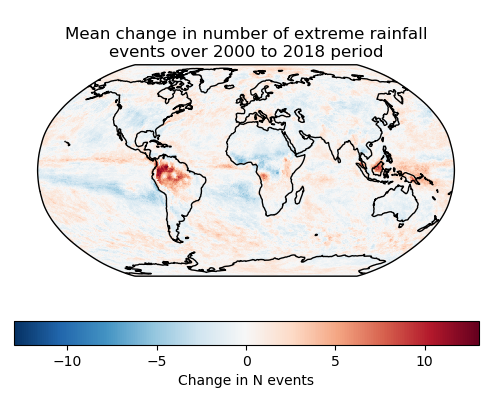

In [6]:
data = event_counts_change.event_count.mean(dim='year')

f, ax = plt.subplots(constrained_layout=False, 
                     subplot_kw=dict(projection=crs.Robinson()))
p = data.plot.pcolormesh(
    transform=crs.PlateCarree(),
    cbar_kwargs={'orientation':'horizontal','label':''}
)
p.colorbar.set_label('Change in N events')

ax.coastlines()

plt.title(f'''
Mean change in number of extreme rainfall
events over 2000 to {MAX_YEAR} period''')

# plt.savefig(RESULTS_FOLDER / f'mean events change 2000-{MAX_YEAR} map.png', 
#             bbox_inches='tight', dpi=600)
plt.savefig(RESULTS_FOLDER / f'mean events change 2000-{MAX_YEAR} map.pdf', 
            bbox_inches='tight', dpi=600)

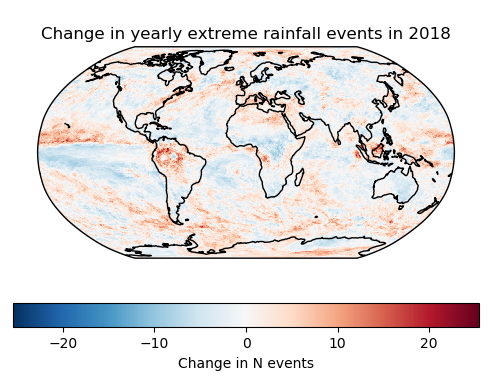

In [16]:
data = event_counts_change.event_count.sel(year=MAX_YEAR)

f, ax = plt.subplots(constrained_layout=False, 
                     subplot_kw=dict(projection=crs.Robinson()))

p = data.plot.pcolormesh(
    transform=crs.PlateCarree(),
    cbar_kwargs={'orientation':'horizontal','label':''}
)
p.colorbar.set_label('Change in N events')

ax.coastlines()

plt.title(f'''
Change in yearly extreme rainfall events in {MAX_YEAR}''')

plt.savefig(RESULTS_FOLDER / f'events change in {MAX_YEAR} map.png', 
            bbox_inches='tight', dpi=600)


Text(0.5, 1.0, 'Change in yearly mean area affected \n by extreme rainfall events')

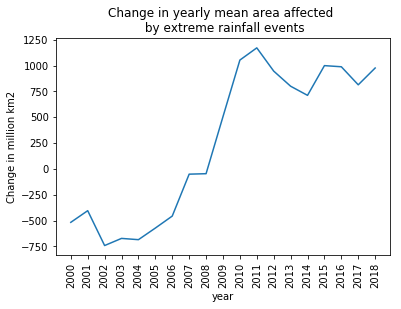

In [20]:
(event_counts_change * areas).mean(dim=['latitude', 'longitude']).plot()
plt.xticks(event_counts_change['year'], rotation=90)
plt.ylabel('Change in million km2')
plt.title('Change in yearly mean area affected \n by extreme rainfall events')
# plt.savefig(RESULTS_FOLDER / 'area_events_ts.png', bbox_inches='tight', dpi=300)

In [22]:
exposure_change_ts = (population * event_counts_change).sum(dim=['latitude', 'longitude'], skipna=True)
exposure_change_ts = exposure_change_ts.to_dataframe()

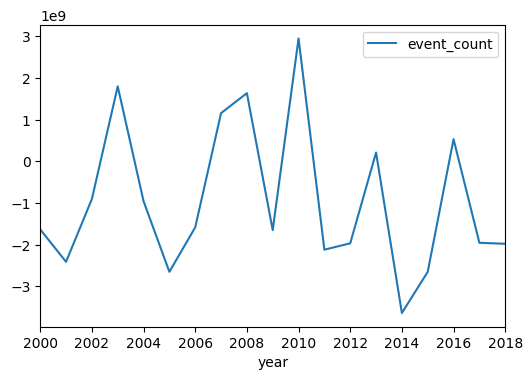

In [24]:
exposure_change_ts.plot()

In [24]:
exposure_change_ts.to_excel(RESULTS_FOLDER / 'exposures_change.xlsx')

In [25]:
exposure_change_ts = pd.read_excel(RESULTS_FOLDER / 'exposures_change.xlsx')

In [26]:
exposure_change_ts = exposure_change_ts.set_index('year')

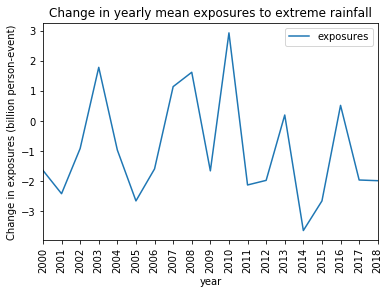

In [27]:
(exposure_change_ts/ 1e9).plot()
plt.xticks(exposure_change_ts.index, rotation=90)
plt.ylabel('Change in exposures (billion person-event)')
plt.title('Change in yearly mean exposures to extreme rainfall')
plt.savefig(RESULTS_FOLDER / 'exposures_change_ts.png', bbox_inches='tight', dpi=300)
plt.savefig(RESULTS_FOLDER / 'exposures_change_ts.pdf', bbox_inches='tight')